# Acoustic FWI parametrized in velocity using only refractions

## Author: M. Ravasi

This notebook performs acoustic FWI parametrized in velocity using only refracted arrivals. It is mostly aimed at showcasing the ``devitofwi.preproc.masking.timespace_mask`` method to mask both the observed and modelled data (the latter as part of the objective function computation).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from devito import configuration
from pylops.basicoperators import Diagonal, Identity

from tqdm.notebook import tqdm
from examples.seismic import AcquisitionGeometry, Model, Receiver
from examples.seismic import plot_velocity, plot_perturbation
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord

from devitofwi.devito.utils import clear_devito_cache
from devitofwi.waveengine.acoustic import AcousticWave2D
from devitofwi.preproc.masking import TimeSpaceMasking
from devitofwi.loss.l2 import L2
from devitofwi.postproc.acoustic import PostProcessVP

configuration['log-level'] = 'ERROR'

In [2]:
clear_devito_cache()

In [3]:
# Callback to track model error
def fwi_callback(xk, vp, vp_error):
    vp_error.append(np.linalg.norm((xk - vp.reshape(-1))/vp.reshape(-1)))

## Parameters 

In [4]:
# Model and aquisition parameters
par = {'nx':601,   'dx':15,    'ox':0,
       'nz':221,   'dz':15,    'oz':0,
       'ns':20,    'ds':300,   'os':1000,  'sz':0,
       'nr':300,   'dr':30,    'or':0,     'rz':0,
       'nt':3000,  'dt':0.002, 'ot':0,
       'freq':7,
       'niters': 5
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

# Time-space mask parameters
vwater = 1500
toff = 0.35

## Acquisition set-up

In [5]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1] * 1e3 # in ms

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

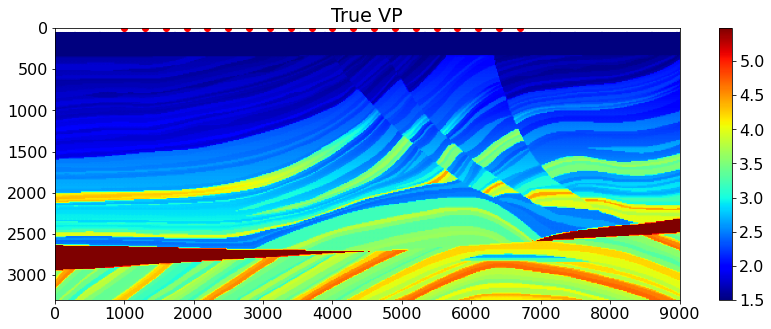

In [6]:
# Function to get water layer mask
def mask(m, value):
    """Mask for model below given value
    """
    msk = m > value
    msk = msk.astype(int)
    return msk

# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(par['nz'], par['nx']).T
msk = mask(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

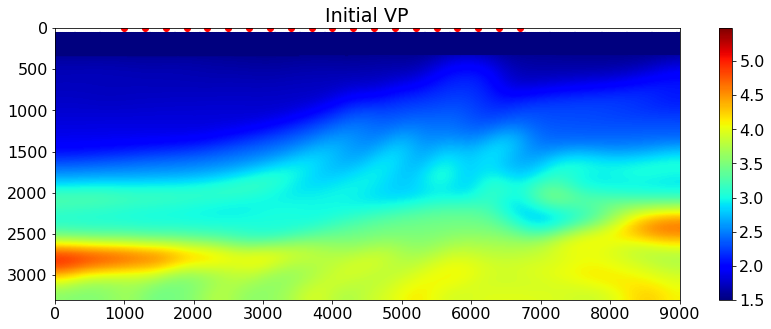

In [7]:
# Initial model for FWI by smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[15,10])
vp_init = vp_init * msk  # to preserve the water layer  
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

In [8]:
# Define modelling engine
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vp=vp_true * 1e3, 
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl);

In [9]:
# Model data
dobs = amod.mod_allshots()

  0%|          | 0/20 [00:00<?, ?it/s]

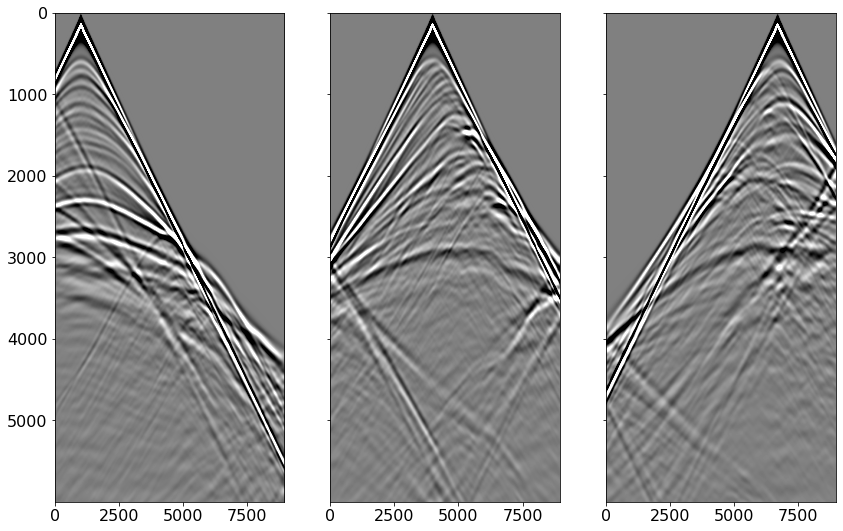

In [10]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)

## Mask creation

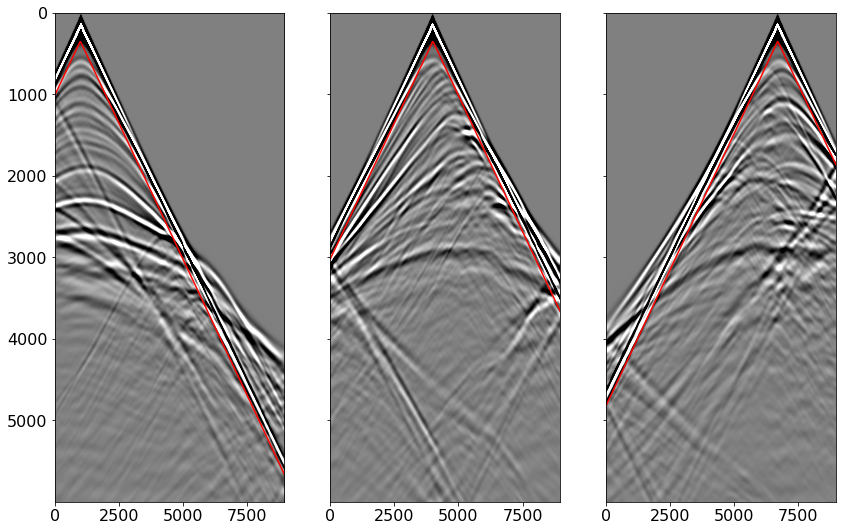

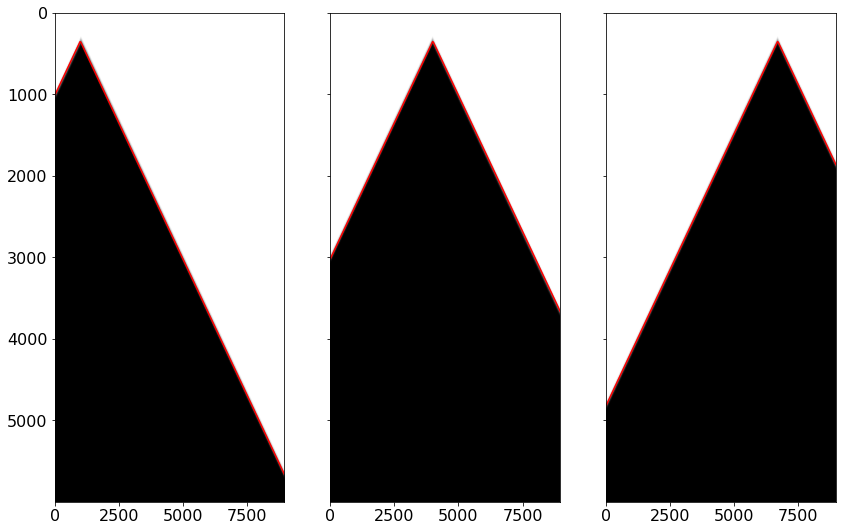

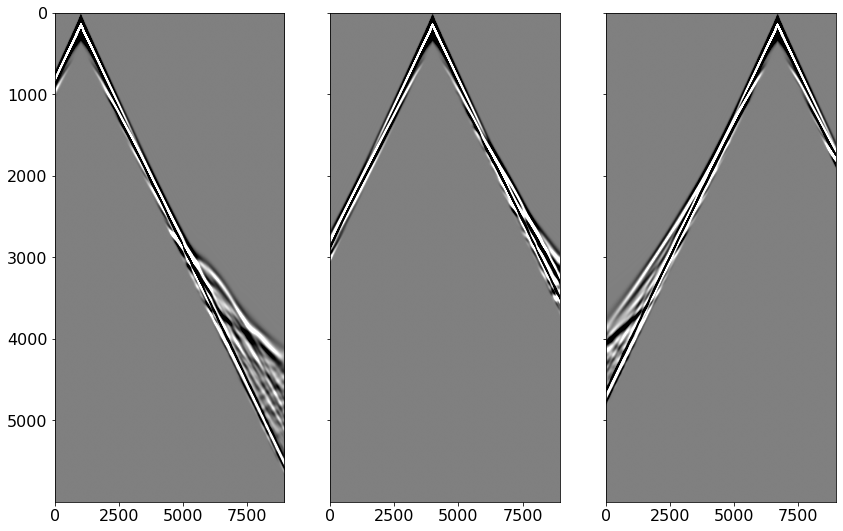

In [11]:
# Create direct arrival mask
distance = np.sqrt((x_s[:, 0][:, None]-x_r[:, 0][None, :])**2 + (x_s[:, 1][:, None]-x_r[:, 1][None, :])**2)
directtime = distance / vwater
tsmask = TimeSpaceMasking(directtime, amod.geometry.nt, amod.geometry.dt * 1e-3, toff, nsmooth=50)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)
    ax.plot(x_r[:, 0], (directtime[ishot] + toff) * 1000, 'r')
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(tsmask.mask[ishot].T, aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=0, vmax=1)
    ax.plot(x_r[:, 0], (directtime[ishot] + toff) * 1000, 'r')
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot] * tsmask.mask[ishot].T, aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax);

## Inversion with L-BFGS

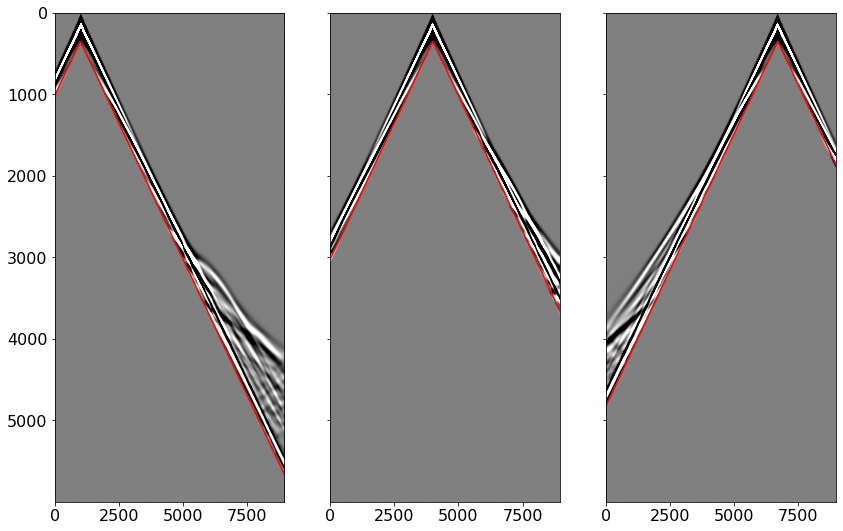

In [12]:
# Mask observed data to have direct arrival and refractions
TSmaskop = [Diagonal(tsmask.mask[isrc].T.ravel()) for isrc in range(par['ns'])]
dobs_masked = np.hstack([(TSmaskop[isrc] @ dobs[isrc].ravel())[None, :] for isrc in range(par['ns'])])
dobs_masked = dobs_masked.reshape(par['ns'], amod.geometry.nt, par['nr'])

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs_masked[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)
    ax.plot(x_r[:, 0], (directtime[ishot] + toff) * 1000, 'r')

In [13]:
# Define loss (to which we add the mask as a diagonal linear operator applied to the modelled data
l2loss = L2(TSmaskop, dobs_masked.reshape(par['ns'], -1))

ainv = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vprange=(vp_true.min() * 1e3, vp_true.max() * 1e3),
                      vpinit=vp_init * 1e3,
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      loss=l2loss);

  0%|          | 0/20 [00:00<?, ?it/s]

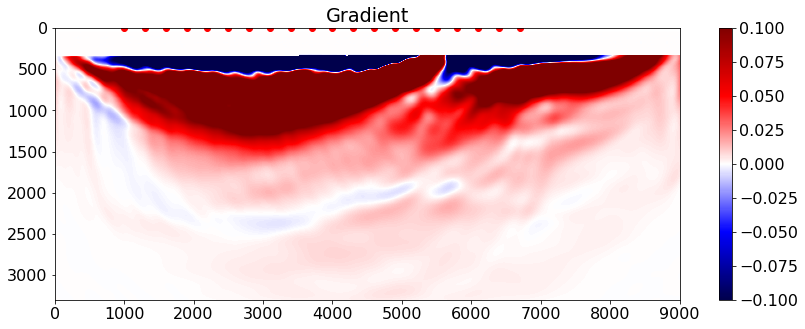

In [14]:
# Compute first gradient and find scaling
postproc = PostProcessVP(scaling=1, mask=msk)
loss, direction = ainv._loss_grad(ainv.initmodel.vp, postprocess=postproc.apply)

scaling = direction.max()

plt.figure(figsize=(14, 5))
plt.imshow(direction.T / scaling, cmap='seismic', vmin=-1e-1, vmax=1e-1, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Gradient')
plt.axis('tight');

In [15]:
# FWI with L-BFGS
ftol = 1e-10
maxiter = 50
maxfun = 5000
vp_error = []

convertvp = None
postproc = PostProcessVP(scaling=scaling, mask=msk).apply

nl = minimize(ainv.loss_grad, vp_init, method='L-BFGS-B', jac=True,
              args=(convertvp, postproc),
              callback=lambda x: fwi_callback(x, vp=vp_true, vp_error=vp_error), 
              options={'ftol':ftol, 'maxiter':maxiter, 'maxfun':maxfun, 'disp':True})

  0%|          | 0/20 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       132821     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.69560D+02    |proj g|=  1.68307D+00


 This problem is unconstrained.


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    1    f=  4.69017D+02    |proj g|=  1.02304D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    2    f=  2.64608D+02    |proj g|=  9.35326D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    3    f=  1.95863D+02    |proj g|=  8.27342D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    4    f=  1.54484D+02    |proj g|=  5.79887D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    5    f=  1.21864D+02    |proj g|=  3.56412D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    6    f=  1.08716D+02    |proj g|=  2.58828D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    7    f=  1.01731D+02    |proj g|=  2.58326D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    8    f=  9.34974D+01    |proj g|=  3.07315D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    9    f=  8.44627D+01    |proj g|=  2.71031D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   10    f=  7.72173D+01    |proj g|=  3.07202D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   11    f=  7.15182D+01    |proj g|=  2.10897D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   12    f=  6.12747D+01    |proj g|=  3.60360D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   13    f=  5.68122D+01    |proj g|=  1.95285D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   14    f=  5.24479D+01    |proj g|=  2.85111D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   15    f=  4.82821D+01    |proj g|=  2.23747D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   16    f=  4.54426D+01    |proj g|=  1.59383D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   17    f=  4.32619D+01    |proj g|=  1.12422D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   18    f=  4.03924D+01    |proj g|=  2.12900D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   19    f=  3.84850D+01    |proj g|=  1.60948D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   20    f=  3.72173D+01    |proj g|=  1.34794D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   21    f=  3.50642D+01    |proj g|=  1.47758D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   22    f=  3.37994D+01    |proj g|=  1.81248D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   23    f=  3.25324D+01    |proj g|=  8.56986D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   24    f=  3.11423D+01    |proj g|=  1.41250D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   25    f=  3.01247D+01    |proj g|=  1.33480D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   26    f=  2.79704D+01    |proj g|=  1.54497D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   27    f=  2.70057D+01    |proj g|=  9.93993D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   28    f=  2.58280D+01    |proj g|=  6.63924D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   29    f=  2.49831D+01    |proj g|=  1.02361D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   30    f=  2.42343D+01    |proj g|=  1.09294D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   31    f=  2.35964D+01    |proj g|=  7.58862D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   32    f=  2.24414D+01    |proj g|=  7.60944D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   33    f=  2.19583D+01    |proj g|=  7.69065D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   34    f=  2.13070D+01    |proj g|=  7.48600D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   35    f=  2.02591D+01    |proj g|=  1.34306D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   36    f=  1.98615D+01    |proj g|=  1.63194D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   37    f=  1.88983D+01    |proj g|=  6.46391D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   38    f=  1.85693D+01    |proj g|=  5.20528D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   39    f=  1.79881D+01    |proj g|=  9.10907D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   40    f=  1.73240D+01    |proj g|=  6.87591D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   41    f=  1.67624D+01    |proj g|=  4.71549D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   42    f=  1.61110D+01    |proj g|=  5.58608D-02


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   43    f=  1.59806D+01    |proj g|=  3.62529D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   44    f=  1.56550D+01    |proj g|=  3.98710D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   45    f=  1.51445D+01    |proj g|=  6.94344D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   46    f=  1.46260D+01    |proj g|=  4.90619D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   47    f=  1.43141D+01    |proj g|=  1.42486D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   48    f=  1.39867D+01    |proj g|=  6.52333D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   49    f=  1.37859D+01    |proj g|=  3.95860D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   50    f=  1.34504D+01    |proj g|=  6.97992D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     50     53      1     0     0   6.980D-02   1.345D+01
  F =   13.450421463986459     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [16]:
nl

      fun: 13.450421463986459
 hess_inv: <132821x132821 LbfgsInvHessProduct with dtype=float64>
      jac: Data([-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       6.16723276e-06,  6.97072611e-06,  7.17278772e-06])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 53
      nit: 50
     njev: 53
   status: 1
  success: False
        x: array([1.5       , 1.5       , 1.5       , ..., 4.08595619, 4.08796866,
       4.08897125])

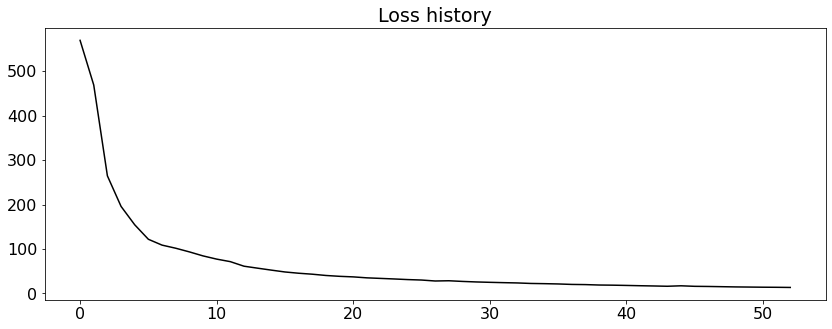

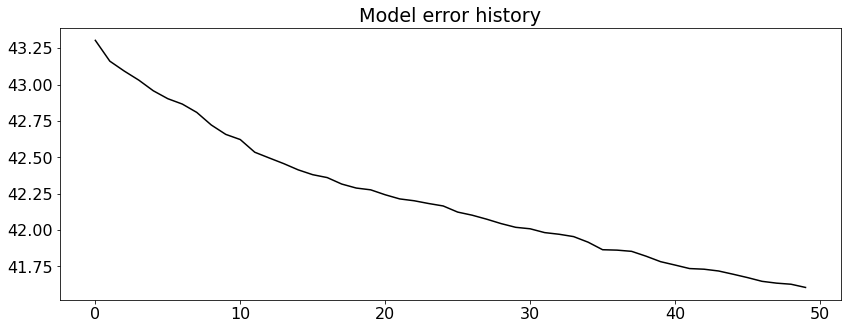

In [17]:
plt.figure(figsize=(14, 5))
plt.plot(ainv.losshistory, 'k')
plt.title('Loss history')

plt.figure(figsize=(14, 5))
plt.plot(vp_error, 'k')
plt.title('Model error history');

(0.0, 9000.0, 3300.0, 0.0)

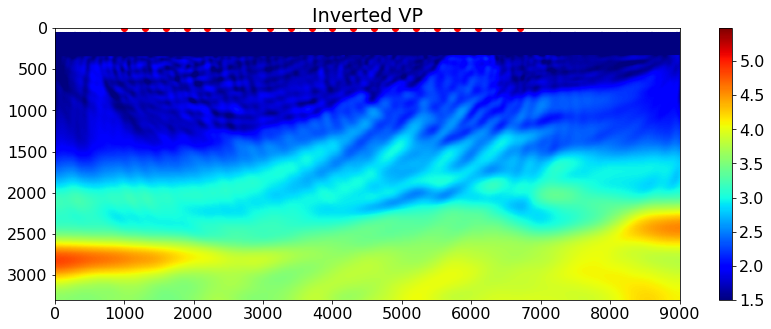

In [18]:
vp_inv = nl.x.reshape(shape)

plt.figure(figsize=(14, 5))
plt.imshow(vp_inv.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Inverted VP')
plt.axis('tight')

In [20]:
# Model data with inverted velocity model and compare with observed data
ainvfinal = AcousticWave2D(shape, origin, spacing, 
                           x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                           0., tmax,  
                           vp=vp_inv * 1e3, 
                           src_type="Ricker", f0=par['freq'],
                           space_order=space_order, nbl=nbl)

#plot_velocity(ainvfinal.model, ainvfinal.geometry.src_positions, 
#              ainvfinal.geometry.rec_positions)

dinv = ainvfinal.mod_allshots(dt=amod.geometry.dt)

  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
# Mask predicted data
dinv_masked = np.hstack([(TSmaskop[isrc] @ dinv[isrc, :dobs.shape[1]].ravel())[None, :] for isrc in range(par['ns'])])
dinv_masked = dinv_masked.reshape(par['ns'], amod.geometry.nt, par['nr'])

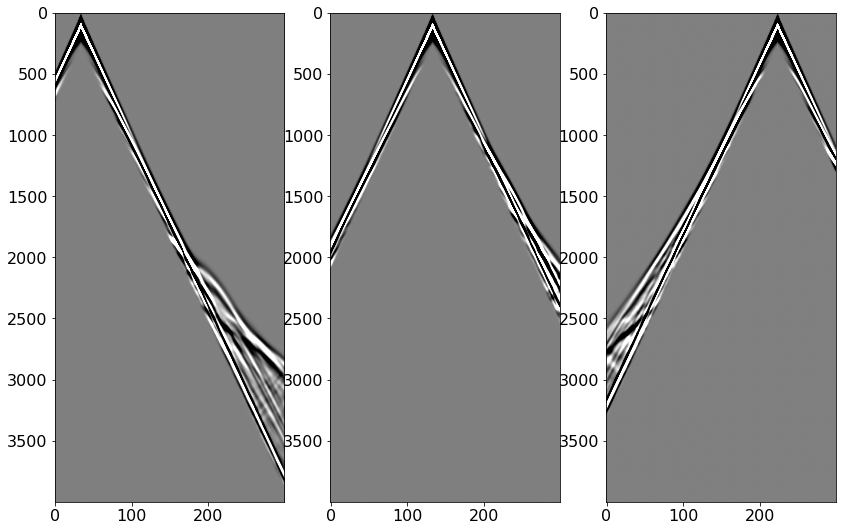

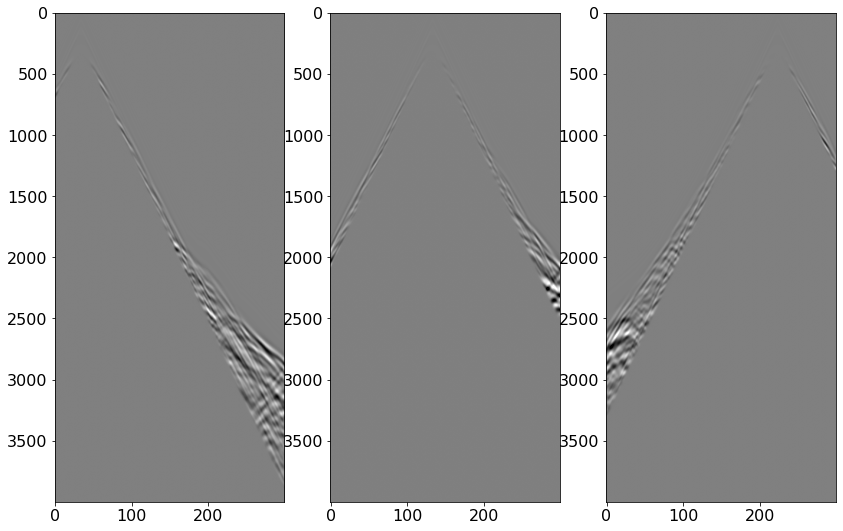

In [22]:
ntmax = 4000
d_vmin, d_vmax = np.percentile(np.hstack(dinv).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dinv_masked[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs_masked[ishot, :ntmax] - dinv_masked[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)